In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
# Primary Admissions information
df = pd.read_csv("ADMISSIONS.csv")

# Patient specific info such as gender
df_pat = pd.read_csv("Length_of_stay/PATIENTS.csv")

# Diagnosis for each admission to hospital
df_diagcode = pd.read_csv("Length_of_stay/DIAGNOSES_ICD.csv")

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv("Length_of_stay/ICUSTAYS.csv")

In [3]:
df

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,41055,44083,198330,2112-05-28 15:45:00,2112-06-07 16:50:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,SINGLE,WHITE,2112-05-28 13:16:00,2112-05-28 17:30:00,PERICARDIAL EFFUSION,0,1
125,41070,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,2178-05-14 17:37:00,2178-05-14 22:08:00,ALTERED MENTAL STATUS,1,1
126,41087,44212,163189,2123-11-24 14:14:00,2123-12-30 14:31:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,NaN,NaN,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,0,1
127,41090,44222,192189,2180-07-19 06:55:00,2180-07-20 13:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,2180-07-19 04:50:00,2180-07-19 08:23:00,BRADYCARDIA,0,1


In [9]:
print('Dataset has {} number of unique admission events.'.format(df['hadm_id'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['subject_id'].nunique()))

Dataset has 129 number of unique admission events.
Dataset has 100 number of unique patients.


In [10]:
# Convert admission and discharge times to datatime type
df['admittime'] = pd.to_datetime(df['admittime'])
df['dischtime'] = pd.to_datetime(df['dischtime'])

In [11]:
df.admittime

0     2164-10-23 21:09:00
1     2126-08-14 22:32:00
2     2125-10-04 23:36:00
3     2149-05-26 17:19:00
4     2163-05-14 20:43:00
              ...        
124   2112-05-28 15:45:00
125   2178-05-14 20:29:00
126   2123-11-24 14:14:00
127   2180-07-19 06:55:00
128   2170-12-15 03:14:00
Name: admittime, Length: 129, dtype: datetime64[ns]

In [12]:
# Calculating the Length of Stay variable using the difference between Discharge time and Admit time 
# Convert timedelta type into float 'days'. Note: There are 86400 seconds in a day
df['LOS'] = (df['dischtime'] - df['admittime']).dt.total_seconds()/86400

In [13]:
df['LOS'].describe()

count    129.000000
mean       9.332332
std       12.720450
min        0.038194
25%        3.314583
50%        6.634028
75%       10.645139
max      123.984722
Name: LOS, dtype: float64

In [14]:
df['LOS']

0       8.837500
1      13.852083
2       2.650694
3       8.057639
4       0.636806
         ...    
124    10.045139
125     0.552778
126    36.011806
127     1.253472
128     9.615278
Name: LOS, Length: 129, dtype: float64

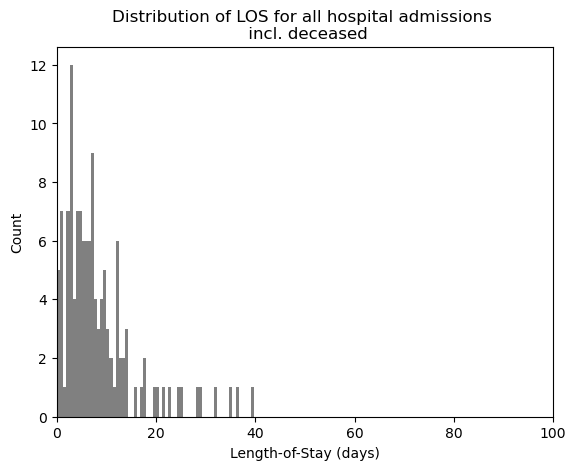

In [20]:
# Plot LOS Distribution
plt.hist(df['LOS'], bins=200, color = '0.5')
plt.xlim(0, 100)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show()

In [21]:
# Dropping the columns that are not needed
df.drop(columns=['dischtime', 'row_id', 
                'edregtime', 'edouttime', 'hospital_expire_flag',
                'has_chartevents_data'], inplace=True)

In [22]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,diagnosis,LOS
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,SEPSIS,8.837500
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,HEPATITIS B,13.852083
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,SEPSIS,2.650694
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,HUMERAL FRACTURE,8.057639
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,ALCOHOLIC HEPATITIS,0.636806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,SINGLE,WHITE,PERICARDIAL EFFUSION,10.045139
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ALTERED MENTAL STATUS,0.552778
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,36.011806
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,BRADYCARDIA,1.253472


In [23]:
# Mapping the dead and alive value of patients who died in hospital as 1 and 0
df['deceased'] = df['deathtime'].notnull().map({True:1, False:0})

In [24]:
print("{} of {} patients died in the hospital".format(df['deceased'].sum(), 
                                                     df['subject_id'].nunique()))

40 of 100 patients died in the hospital


In [25]:
# Descriptive analysis of patients who died during the stay in ICU
df['LOS'].loc[df['deceased'] == 0].describe()

count     89.000000
mean       9.766526
std       13.934030
min        0.980556
25%        4.104167
50%        6.830556
75%       10.146528
max      123.984722
Name: LOS, dtype: float64

In [26]:
# Club the Ethnicity categories into 5 broad categories
df['ethnicity'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ethnicity'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ethnicity'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ethnicity'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ethnicity'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
df['ethnicity'].loc[~df['ethnicity'].isin(df['ethnicity'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
df['ethnicity'].value_counts()

ethnicity
WHITE                     86
OTHER/UNKNOWN             17
HISPANIC/LATINO           17
BLACK/AFRICAN AMERICAN     7
ASIAN                      2
Name: count, dtype: int64

In [27]:
# Bar plot function
def plot_los_groupby(variable, size=(7,4)):
    
    #Plot Median LOS by df categorical series name 
    
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    
    #Boxplot of LOS by df categorical series name 
    
    results = df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df['LOS'].loc[df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();



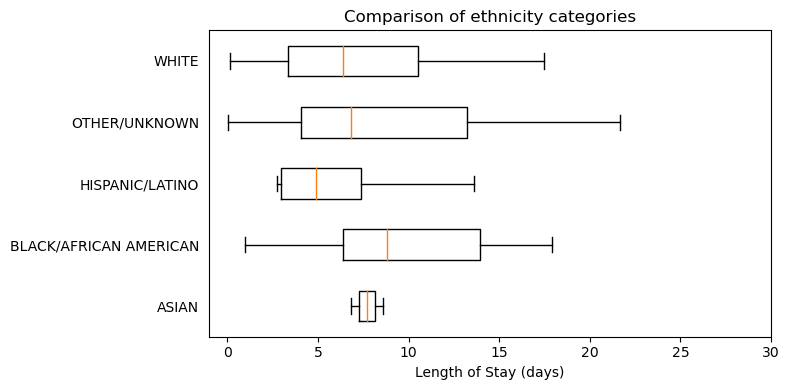

In [29]:
boxplot_los_groupby('ethnicity', los_range=(-1, 30))

In [30]:
df['admission_type'].value_counts()

admission_type
EMERGENCY    119
ELECTIVE       8
URGENT         2
Name: count, dtype: int64

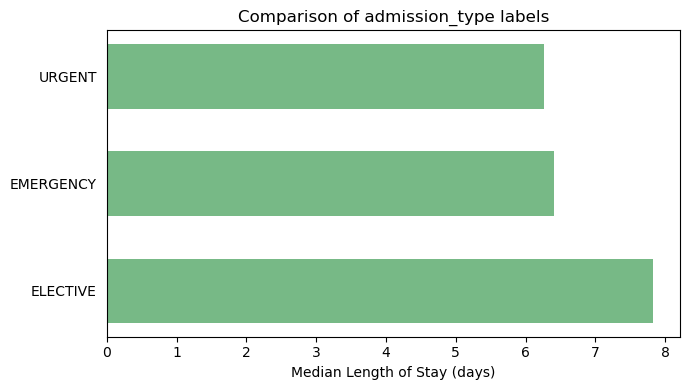

In [31]:
plot_los_groupby('admission_type')

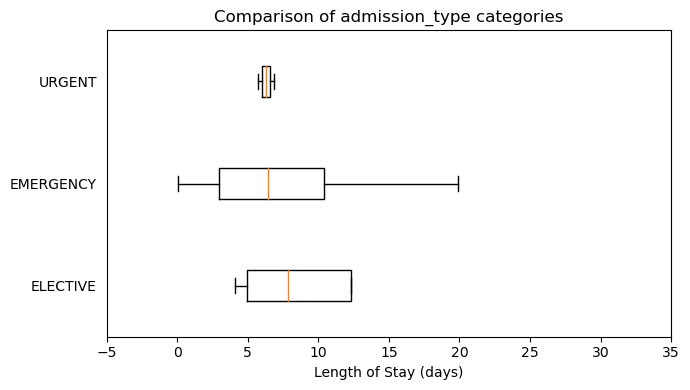

In [32]:
boxplot_los_groupby('admission_type', los_range=(-5, 35), size=(7, 4))

In [33]:
df['insurance'].value_counts()

insurance
Medicare      98
Private       24
Medicaid       6
Government     1
Name: count, dtype: int64

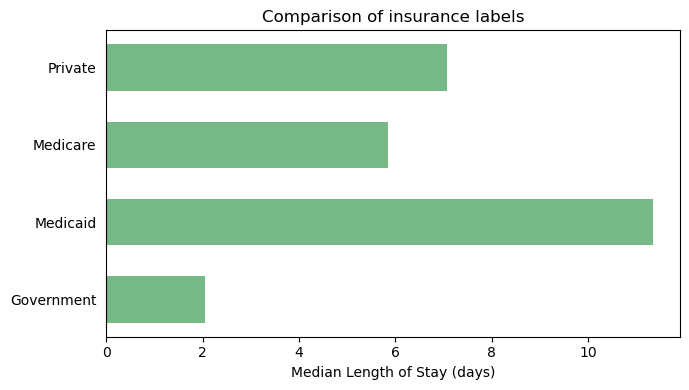

In [34]:
plot_los_groupby('insurance')

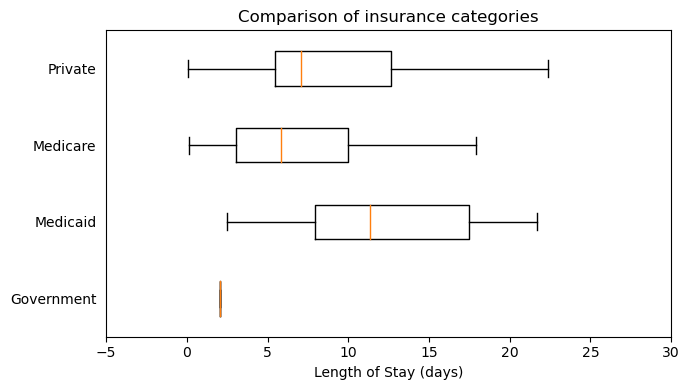

In [35]:
boxplot_los_groupby('insurance', los_range=(-5, 30), size=(7, 4))

In [36]:
df['marital_status'].value_counts(dropna=False)

marital_status
MARRIED              60
SINGLE               26
NaN                  16
WIDOWED              15
DIVORCED              6
UNKNOWN (DEFAULT)     5
SEPARATED             1
Name: count, dtype: int64

In [37]:
# Replacing NAs as'UNKNOWN'
df['marital_status'] = df['marital_status'].fillna('UNKNOWN (DEFAULT)')
df['marital_status'].value_counts(dropna=False)

marital_status
MARRIED              60
SINGLE               26
UNKNOWN (DEFAULT)    21
WIDOWED              15
DIVORCED              6
SEPARATED             1
Name: count, dtype: int64

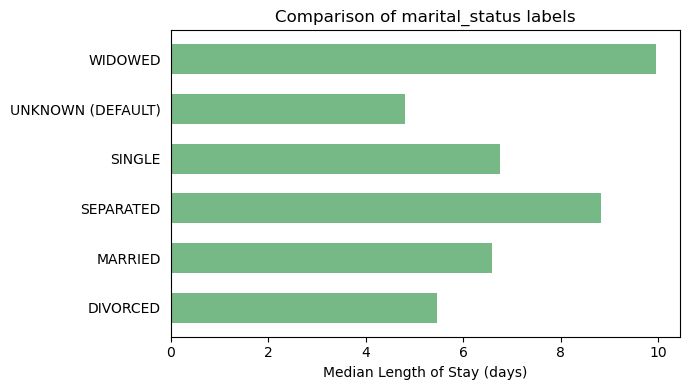

In [38]:
plot_los_groupby('marital_status')

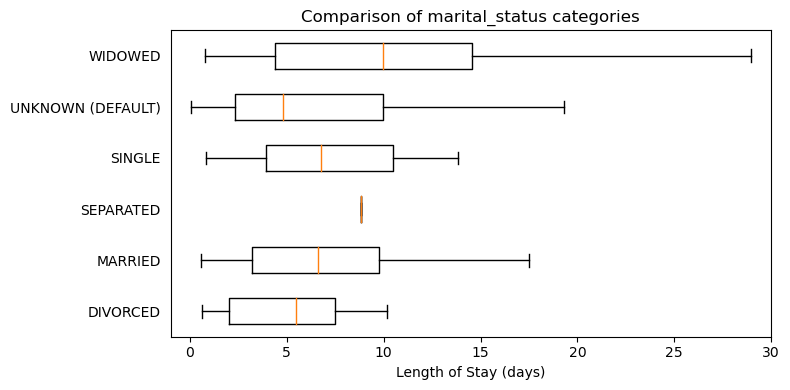

In [39]:
boxplot_los_groupby('marital_status')

In [40]:
df

,subject_id,hadm_id,admittime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,diagnosis,LOS,deceased
0,10006,142345,2164-10-23 21:09:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,SEPSIS,8.837500,0
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,OTHER/UNKNOWN,HEPATITIS B,13.852083,1
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,UNKNOWN (DEFAULT),OTHER/UNKNOWN,SEPSIS,2.650694,1
3,10017,199207,2149-05-26 17:19:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,HUMERAL FRACTURE,8.057639,0
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,ALCOHOLIC HEPATITIS,0.636806,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,44083,198330,2112-05-28 15:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,ENGL,CATHOLIC,SINGLE,WHITE,PERICARDIAL EFFUSION,10.045139,0
125,44154,174245,2178-05-14 20:29:00,2178-05-15 09:45:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,ENGL,PROTESTANT QUAKER,MARRIED,WHITE,ALTERED MENTAL STATUS,0.552778,1
126,44212,163189,2123-11-24 14:14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,REHAB/DISTINCT PART HOSP,Medicare,ENGL,UNOBTAINABLE,SINGLE,BLACK/AFRICAN AMERICAN,ACUTE RESPIRATORY DISTRESS SYNDROME;ACUTE RENA...,36.011806,0
127,44222,192189,2180-07-19 06:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,BRADYCARDIA,1.253472,0


## DIAGNOSES_ICD Dataset

Because it's not feasible to have 6985 unique values to use as features for predicting LOS, The diagnosis were reduced into more general categories. After researching the ICD9 coding methodology, the super categories in which the diagnosis codes are arranged are as follows:

001–139: infectious and parasitic diseases\
140–239: neoplasms\
240–279: endocrine, nutritional and metabolic diseases, and immunity disorders\
280–289: diseases of the blood and blood-forming organs\
290–319: mental disorders\
320–389: diseases of the nervous system and sense organs\
390–459: diseases of the circulatory system\
460–519: diseases of the respiratory system\
520–579: diseases of the digestive system\
580–629: diseases of the genitourinary system\
630–679: complications of pregnancy, childbirth, and the puerperium\
680–709: diseases of the skin and subcutaneous tissue\
710–739: diseases of the musculoskeletal system and connective tissue\
740–759: congenital anomalies\
760–779: certain conditions originating in the perinatal period\
780–799: symptoms, signs, and ill-defined conditions\
800–999: injury and poisoning\
E and V codes: external causes of injury and supplemental classification, using 999 as placeholder even though it overlaps with complications of medical care\
Source of these categories: https://en.wikipedia.org/wiki/List_of_ICD-9_codes

In [41]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code
0,112344,10006,142345,1,99591
1,112345,10006,142345,2,99662
2,112346,10006,142345,3,5672
3,112347,10006,142345,4,40391
4,112348,10006,142345,5,42731
...,...,...,...,...,...
1756,397673,44228,103379,7,1975
1757,397674,44228,103379,8,45182
1758,397675,44228,103379,9,99592
1759,397676,44228,103379,10,2449


In [42]:
# Filter out E and V codes since processing will be done on the numeric first 3 values
df_diagcode['recode'] = df_diagcode['icd9_code']
df_diagcode['recode'] = df_diagcode['recode'][~df_diagcode['recode'].str.contains("[a-zA-Z]").fillna(False)]
df_diagcode['recode'].fillna(value='999', inplace=True)

In [43]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code,recode
0,112344,10006,142345,1,99591,99591
1,112345,10006,142345,2,99662,99662
2,112346,10006,142345,3,5672,5672
3,112347,10006,142345,4,40391,40391
4,112348,10006,142345,5,42731,42731
...,...,...,...,...,...,...
1756,397673,44228,103379,7,1975,1975
1757,397674,44228,103379,8,45182,45182
1758,397675,44228,103379,9,99592,99592
1759,397676,44228,103379,10,2449,2449


In [44]:
df_diagcode['recode'] = df_diagcode['recode'].str.slice(start=0, stop=3, step=1)
df_diagcode['recode'] = df_diagcode['recode'].astype(int)

In [45]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    df_diagcode['recode'] = np.where(df_diagcode['recode'].between(cat_range[0],cat_range[1]), 
            num, df_diagcode['recode'])
    
# Convert integer to category name using diag_dict
df_diagcode['recode'] = df_diagcode['recode']
df_diagcode['cat'] = df_diagcode['recode'].replace(diag_dict)

In [46]:
df_diagcode

,row_id,subject_id,hadm_id,seq_num,icd9_code,recode,cat
0,112344,10006,142345,1,99591,16,injury
1,112345,10006,142345,2,99662,16,injury
2,112346,10006,142345,3,5672,8,digestive
3,112347,10006,142345,4,40391,6,circulatory
4,112348,10006,142345,5,42731,6,circulatory
...,...,...,...,...,...,...,...
1756,397673,44228,103379,7,1975,1,neoplasms
1757,397674,44228,103379,8,45182,6,circulatory
1758,397675,44228,103379,9,99592,16,injury
1759,397676,44228,103379,10,2449,2,endocrine


In [48]:
# Create list of diagnoses for each admission
hadm_list = df_diagcode.groupby('hadm_id')['cat'].apply(list).reset_index()